In [2]:
import numpy as np
import warnings
from scipy import linalg
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.patches import Rectangle
plt.rcParams["animation.html"] = "jshtml"

In [3]:
def make_system(Kp=70, Ki=20, Kd=1, Ks=9, dt=0.02, Tend=18, L=None, N1=10):
    T = np.arange(0, Tend + dt, dt)
    kI1=Ki            # kI=5
    kP1=Kp   # Replace with the desired value for kP1
    ks = 9
    c = 200  # Replace with the desired value for c
    m = 1000  # Replace with the desired value for m
    r = 1
    kI=kI1*ks
    kP=kP1*ks

    alpha = 0.1
    A = np.array([[-c / m, kI1 * ks / m], [0, 0]])
    B = np.array([[kP1 * ks / m], [Kd]])
    C = np.array([[1, 0]])
    D = 0
    X0 = np.zeros((1,2))

    if L is None:
        G_adj = np.tril(np.ones((N1, N1)), -1)
        L = np.diag(G_adj.sum(axis=1)) - G_adj
    # Normalize communication matrix
    L_norm = np.zeros((N1, N1))
    for k1 in range(N1):
        if L[k1, k1] != 0:
            for k2 in range(N1):
                L_norm[k1, k2] = L[k1, k2] / L[k1, k1]
    # L_norm = L
    # Augmented state-space matrices (consider using control system libraries for efficiency)
    Abar = np.kron(np.eye(N1), A) - np.kron(L_norm, np.dot(B, C))
    # Abar = np.kron(np.diag(np.ones(N1)), A) - np.kron(L_norm, B @ C)
    Bbar = np.zeros((N1 * 2, 1))
    Cbar = np.kron(np.eye(N1), C)
    Dbar = np.zeros((N1, 1))

    # Initial states
    v0 = np.ones(N1) * 5
    v0[0] = 10
    X0 = np.zeros(2 * N1)
    if (Kp == 0) and (Ki == 0):
        X0[1::2] = np.arange(N1)[::-1]
        X0[::2] = 5
        X0[0] = 10
    else:
        for k1 in range(N1):
            X0[2 * k1] = v0[k1]
            # X0[2 * k1 + 1] = c / kI * v0[k1]
            X0[2 * k1 + 1] = -0.8*k1 + (c / kI * v0[k1])

    return Abar, Bbar, Cbar, Dbar, T, X0, dt


In [9]:
G_adj = np.tril(np.ones((N1, N1)), -1)
L = np.diag(G_adj.sum(axis=1)) - G_adj
L

array([[ 0.,  0.,  0.,  0.,  0.],
       [-1.,  1.,  0.,  0.,  0.],
       [-1., -1.,  2.,  0.,  0.],
       [-1., -1., -1.,  3.,  0.],
       [-1., -1., -1., -1.,  4.]])

In [4]:
def sim_collision(Abar, Bbar, Cbar, T, X0, collide_at=700, collision_factor=0.0, dt=0.02):
    n_states = Abar.shape[0]
    n_inputs = Bbar.shape[1]
    n_outputs = Cbar.shape[0]
    n_steps = T.shape[0]
    U = np.zeros((1, n_steps))
    xout = np.zeros((n_states, n_steps))
    xout[:, 0] = X0
    yout = np.zeros((n_outputs, n_steps))
    M = np.block([[Abar * dt, Bbar * dt, np.zeros((n_states, n_inputs))],
                    [np.zeros((n_inputs, n_states + n_inputs)),
                    np.identity(n_inputs)],
                    [np.zeros((n_inputs, n_states + 2 * n_inputs))]])
    expM = linalg.expm(M)
    Ad = expM[:n_states, :n_states]
    Bd1 = expM[:n_states, n_states+n_inputs:]
    Bd0 = expM[:n_states, n_states:n_states + n_inputs] - Bd1
    for i in range(1, n_steps):
        if i >= collide_at:
            xout[0,i-1] *= collision_factor 
        xout[:, i] = (Ad @ xout[:, i-1]
                        + Bd0 @ U[:, i-1] + Bd1 @ U[:, i])
    yout = Cbar @ xout

    return yout

In [5]:
def make_animation(positions, dt=0.02, xlim=None, title="With PI Controller and Custom L"):
    fig, ax = plt.subplots()

    scat = ax.scatter(0, 0, c="b", s=5)
    if xlim is None:
        xlim = [int(positions.min()) - 1, int(positions[:, 0].max()) + 1]
    ax.set(xlim=xlim, ylim=[-0.01, 0.01], xlabel='Position [m]')
    ax.set_title(title)
    # ax.set(xlim=[-2, 400], ylim=[-4, 10], xlabel='Time [s]', ylabel='Z [m]')
    ax.legend()
    N = positions.shape[1]
    car_colors = plt.cm.viridis(np.linspace(0, 1, N))
    CAR_WIDTH = 4
    CAR_HEIGHT = 2
    def update(frame):
        # for each frame, update  the data stored on each artist.
        y = positions[frame,:].T
        
        # ax.set_label(f'Time: {np.round(frame*dt, 2)}s')
        # for i in range(N1):
        i = 0
        # car_rect = Rectangle(xy=(0, y[i] - CAR_WIDTH/2), width=CAR_WIDTH, height=CAR_HEIGHT, color=car_colors[i])
        # update the scatter plot:
        data = np.stack([y, [0.0]*N]).T
        scat.set_offsets(data)
        scat.set_sizes([25.0]*N)
        # scat.set_capstyle
        scat.set_facecolors(car_colors)
        scat.set_label("Time: %.2f s"%(frame*dt))
        ax.legend()
        # scat.set_label()
        # scat.
        # ax.add_patch(car_rect)
        return scat


    ani = animation.FuncAnimation(fig=fig, func=update, frames=positions.shape[0], interval=30)
    plt.close()
    return ani 

## When the leading car stops abrutly and sytem is modeled with a PI controller and a custom L.

Text(0, 0.5, 'Velocity (m/s)')

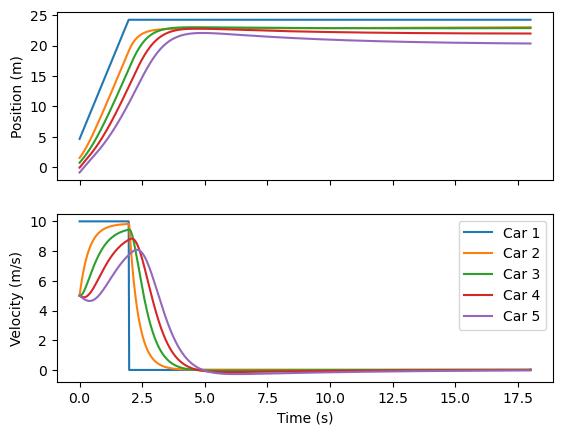

In [6]:
N1 = 5
L = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [-1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, -1, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, -1, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, -1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, -1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, -1, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, -1, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, -1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, -1, 1]])

L = L[:5, :5]

Abar, Bbar, Cbar, _, T, X0, dt = make_system(Kp=300, Ki=50, N1=N1, L=L)
yout = sim_collision(Abar=Abar, Bbar=Bbar, Cbar=Cbar, T=T, X0=X0, collide_at=100, collision_factor=0.0)
positions = np.cumsum(yout.reshape(N1,-1), axis=1).T*dt + X0[1::2]
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(T, positions)
axs[1].plot(T, yout.T)
plt.legend(['Car 1', 'Car 2', 'Car 3', 'Car 4', 'Car 5', 'Car 6', 'Car 7', 'Car 8', 'Car 9', 'Car 10'])
axs[1].set_xlabel("Time (s)")
axs[0].set_ylabel("Position (m)")
axs[1].set_ylabel("Velocity (m/s)")

In [7]:
X0

array([10.        ,  4.44444444,  5.        ,  1.42222222,  5.        ,
        0.62222222,  5.        , -0.17777778,  5.        , -0.97777778])

In [36]:
ani = make_animation(positions[:400,:], dt=dt)
ani.save("custom_L_collision.gif")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


## When the leading car stops abrutly and sytem is modeled with a PI controller and Good L.

Text(0, 0.5, 'Velocity (m/s)')

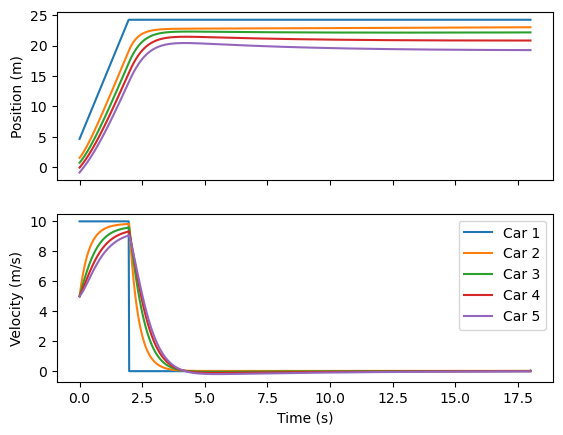

In [37]:
N1 = 5
Abar, Bbar, Cbar, _, T, X0, dt = make_system(Kp=300, Ki=50, N1=N1)
yout = sim_collision(Abar=Abar, Bbar=Bbar, Cbar=Cbar, T=T, X0=X0, collide_at=100, collision_factor=0.0)
positions = np.cumsum(yout.reshape(N1,-1), axis=1).T*dt + X0[1::2]
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(T, positions)
axs[1].plot(T, yout.T)
plt.legend(['Car 1', 'Car 2', 'Car 3', 'Car 4', 'Car 5', 'Car 6', 'Car 7', 'Car 8', 'Car 9', 'Car 10'])
axs[1].set_xlabel("Time (s)")
axs[0].set_ylabel("Position (m)")
axs[1].set_ylabel("Velocity (m/s)")

In [38]:
ani = make_animation(positions[:400,:], dt=dt, title="With PI controller and Good L.")
ani.save("no_collision_pid_and_good_communication.gif")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


## When the leading car stops abrutly and sytem is modeled without a PI controller and Good L.

Text(0, 0.5, 'Velocity (m/s)')

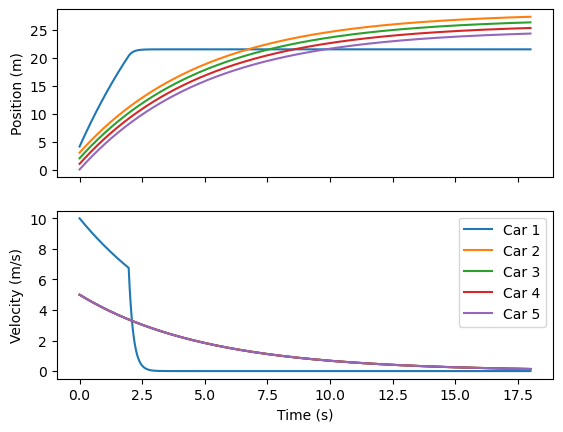

In [39]:
N1 = 5
Abar, Bbar, Cbar, _, T, X0, dt = make_system(Kp=0, Ki=0, N1=5)
yout = sim_collision(Abar=Abar, Bbar=Bbar, Cbar=Cbar, T=T, X0=X0, collide_at=100, collision_factor=0.9)
positions = np.cumsum(yout.reshape(N1,-1), axis=1).T*dt + X0[1::2]
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(T, positions)
axs[1].plot(T, yout.T)
plt.legend(['Car 1', 'Car 2', 'Car 3', 'Car 4', 'Car 5', 'Car 6', 'Car 7', 'Car 8', 'Car 9', 'Car 10'])
axs[1].set_xlabel("Time (s)")
axs[0].set_ylabel("Position (m)")
axs[1].set_ylabel("Velocity (m/s)")

In [40]:
ani = make_animation(positions=positions, title="Without PI controller and Good L.")
ani.save("collision_no_PI_good_L.gif")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


## When there is not abrupt stopping of leading car.

Text(0, 0.5, 'Velocity (m/s)')

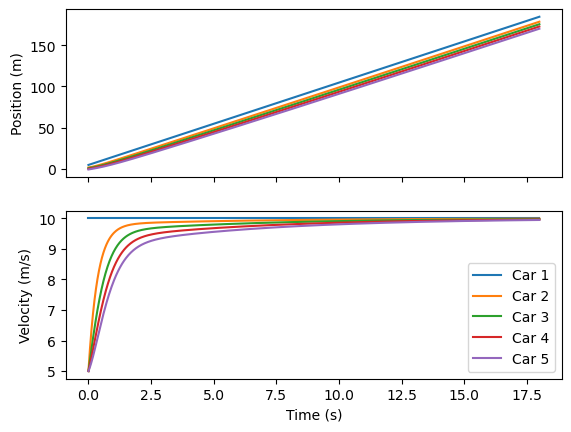

In [41]:
N1 = 5
Abar, Bbar, Cbar, _, T, X0, dt = make_system(Kp=300, Ki=50, N1=N1)
yout = sim_collision(Abar=Abar, Bbar=Bbar, Cbar=Cbar, T=T, X0=X0, collide_at=1000, collision_factor=0.0)
positions = np.cumsum(yout.reshape(N1,-1), axis=1).T*dt + X0[1::2]
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(T, positions)
axs[1].plot(T, yout.T)
plt.legend(['Car 1', 'Car 2', 'Car 3', 'Car 4', 'Car 5', 'Car 6', 'Car 7', 'Car 8', 'Car 9', 'Car 10'])
axs[1].set_xlabel("Time (s)")
axs[0].set_ylabel("Position (m)")
axs[1].set_ylabel("Velocity (m/s)")

In [1]:
X0

NameError: name 'X0' is not defined